# Insurance Prediction Challenge

## Context

https://zindi.africa/competitions/insurance-prediction-challenge

## 0. Préalable

### Importation des modules

In [137]:
# numerical calculation
import numpy as np
# dataframe
import pandas as pd
# vizualisation
import matplotlib.pyplot as plt
import seaborn as sns
# models
from catboost import CatBoostClassifier
# splitting
from sklearn.model_selection import train_test_split, StratifiedKFold
# encoding
from sklearn.preprocessing import OrdinalEncoder
# scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler
# metrics
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
# utils
import random
from datetime import datetime as dt
# saving model
import joblib

In [ ]:
pd.options.display.max_rows = None
pd.options.display.max_columns = None
pd.options.display.max_colwidth = None

In [49]:
# Set seed for reproducability
SEED = 12
random.seed(SEED)
np.random.seed(SEED)

### Chargement des jeux de données

In [3]:
DATA_PATH = 'data/'
train = pd.read_csv(DATA_PATH + 'train_data.csv')
test = pd.read_csv(DATA_PATH + 'test_data.csv')
sample_submission = pd.read_csv(DATA_PATH + 'SampleSubmission.csv')
variable_description = pd.read_csv(DATA_PATH + 'VariableDescription.csv')

In [4]:
train.head(3)

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,H14663,2013,1.0,0,N,V,V,U,290.0,1,1960.0,.,1053,0
1,H2037,2015,1.0,0,V,N,O,R,490.0,1,1850.0,4,1053,0
2,H3802,2014,1.0,0,N,V,V,U,595.0,1,1960.0,.,1053,0


In [5]:
test.head(3)

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code
0,H11920,2013,1.000000,0,V,N,O,R,300.0,1,1960.0,3,3310
1,H11921,2016,0.997268,0,V,N,O,R,300.0,1,1960.0,3,3310
2,H9805,2013,0.369863,0,V,V,V,U,790.0,1,1960.0,.,3310


Variables identifiant et objectif

In [6]:
ID = 'Customer Id'
TARGET = 'Claim'

## 1. Analyse exploratoire

### 1.1. Analyse de la forme

Dimension du dataset

In [50]:
# Let’s observe the shape of our datasets.
print('Dimension du train set :', train.shape)
print('Dimension du test set :', test.shape)

Dimension du train set : (7160, 14)
Dimension du test set : (3069, 14)


Ratio entre train et test sets

In [9]:
# proportion de l'ensemble de test par rapport à l'ensemble d'apprentissage 
test.shape[0] * 100 / (train.shape[0] + test.shape[0])

30.00293283800958

Description du type des variables

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7160 entries, 0 to 7159
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer Id         7160 non-null   object 
 1   YearOfObservation   7160 non-null   int64  
 2   Insured_Period      7160 non-null   float64
 3   Residential         7160 non-null   int64  
 4   Building_Painted    7160 non-null   object 
 5   Building_Fenced     7160 non-null   object 
 6   Garden              7153 non-null   object 
 7   Settlement          7160 non-null   object 
 8   Building Dimension  7054 non-null   float64
 9   Building_Type       7160 non-null   int64  
 10  Date_of_Occupancy   6652 non-null   float64
 11  NumberOfWindows     7160 non-null   object 
 12  Geo_Code            7058 non-null   object 
 13  Claim               7160 non-null   int64  
dtypes: float64(3), int64(4), object(7)
memory usage: 783.3+ KB


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3069 entries, 0 to 3068
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer Id         3069 non-null   object 
 1   YearOfObservation   3069 non-null   int64  
 2   Insured_Period      3069 non-null   float64
 3   Residential         3069 non-null   int64  
 4   Building_Painted    3069 non-null   object 
 5   Building_Fenced     3069 non-null   object 
 6   Garden              3065 non-null   object 
 7   Settlement          3069 non-null   object 
 8   Building Dimension  3056 non-null   float64
 9   Building_Type       3069 non-null   int64  
 10  Date_of_Occupancy   2341 non-null   float64
 11  NumberOfWindows     3069 non-null   object 
 12  Geo_Code            3056 non-null   object 
dtypes: float64(3), int64(3), object(7)
memory usage: 311.8+ KB


Description des colonnes

In [54]:
def afficher_value_counts(df: pd.DataFrame) -> None:
    for colonne in list(df.columns):
        print(colonne)
        print(df[colonne].value_counts(), '\n')

afficher_value_counts(train)

Customer Id
Customer Id
H14663    1
H19182    1
H1571     1
H15027    1
H15026    1
H14466    1
H14465    1
H6530     1
H6304     1
H5417     1
H6267     1
H4680     1
H14445    1
H5388     1
H17594    1
H16776    1
H16775    1
H4135     1
H4134     1
H7035     1
H18013    1
H5244     1
H5243     1
H3143     1
H12828    1
H4303     1
H1631     1
H18308    1
H3403     1
H404      1
H15683    1
H18488    1
H18487    1
H360      1
H18776    1
H14247    1
H7166     1
H2673     1
H4427     1
H406      1
H405      1
H2006     1
H2552     1
H6566     1
H6565     1
H17294    1
H6377     1
H5797     1
H5796     1
H5749     1
H4255     1
H4253     1
H2905     1
H2553     1
H4302     1
H17897    1
H15071    1
H1877     1
H6302     1
H5563     1
H5104     1
H4384     1
H4306     1
H4152     1
H4151     1
H19252    1
H19048    1
H1899     1
H1898     1
H18748    1
H1533     1
H18747    1
H18534    1
H12915    1
H12914    1
H12931    1
H5381     1
H5380     1
H5350     1
H4926     1
H15103    1
H151

In [55]:
afficher_value_counts(test)

Customer Id
Customer Id
H11920    1
H1186     1
H9420     1
H9411     1
H9421     1
H9422     1
H11798    1
H10217    1
H10674    1
H9867     1
H1185     1
H1199     1
H7488     1
H1200     1
H1201     1
H12238    1
H973      1
H975      1
H976      1
H977      1
H9257     1
H9258     1
H7489     1
H7487     1
H9951     1
H10823    1
H7759     1
H8656     1
H8660     1
H8449     1
H10147    1
H9409     1
H95       1
H8807     1
H8808     1
H12450    1
H10554    1
H11570    1
H92       1
H11219    1
H11220    1
H11221    1
H11404    1
H8805     1
H8452     1
H10553    1
H10779    1
H9952     1
H11564    1
H7907     1
H11995    1
H9478     1
H9479     1
H9787     1
H11955    1
H754      1
H11656    1
H12074    1
H12591    1
H9408     1
H1063     1
H10889    1
H1012     1
H1021     1
H1023     1
H1025     1
H1034     1
H1035     1
H1037     1
H10151    1
H1064     1
H9541     1
H9953     1
H8951     1
H10950    1
H8626     1
H10629    1
H11474    1
H7745     1
H869      1
H870      1
H873

Analyse des variables qualitatives

In [11]:
train.describe(include='object')

,Customer Id,Building_Painted,Building_Fenced,Garden,Settlement,NumberOfWindows,Geo_Code
count,7160,7160,7160,7153,7160,7160,7058
unique,7160,2,2,2,2,11,1307
top,H14663,V,N,O,R,.,6088
freq,1,5382,3608,3602,3610,3551,143


- La colonne `NumberOfWindows` contient des chiffres de 1 à 9 et deux valeurs spéciales : un point (.) et une description mathématique (>=10). Ce qui a fait de cette colonne une variable _object_. Pour un apprentissage correct, nous transformerons ces deux valeurs spéciales en chiffres, soit 0 et 10 respectivement. <br>
- La colonne `Geo_Code` a l'air de ne contenir que des nombres mais il s'avère qu'elle est de type _object_.

Analyse des variables quantitatives

In [12]:
train.describe(include='number').round(2)

,YearOfObservation,Insured_Period,Residential,Building Dimension,Building_Type,Date_of_Occupancy,Claim
count,7160.00,7160.00,7160.00,7054.00,7160.00,6652.00,7160.00
mean,2013.67,0.91,0.31,1883.73,2.19,1964.46,0.23
std,1.38,0.24,0.46,2278.16,0.94,36.00,0.42
min,2012.00,0.00,0.00,1.00,1.00,1545.00,0.00
25%,2012.00,1.00,0.00,528.00,2.00,1960.00,0.00
50%,2013.00,1.00,0.00,1083.00,2.00,1970.00,0.00
75%,2015.00,1.00,1.00,2289.75,3.00,1980.00,0.00
max,2016.00,1.00,1.00,20940.00,4.00,2016.00,1.00


Analyse des données manquantes

In [13]:
train.isnull().sum() / train.shape[0] * 100

Customer Id           0.000000
YearOfObservation     0.000000
Insured_Period        0.000000
Residential           0.000000
Building_Painted      0.000000
Building_Fenced       0.000000
Garden                0.097765
Settlement            0.000000
Building Dimension    1.480447
Building_Type         0.000000
Date_of_Occupancy     7.094972
NumberOfWindows       0.000000
Geo_Code              1.424581
Claim                 0.000000
dtype: float64

### 1.2. Analyse du fond

Analyse et visualisation de la target

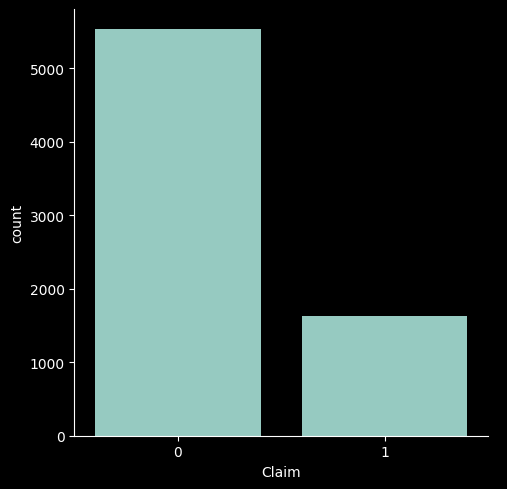

In [65]:
# explorons la distribution de la target
sns.catplot(data=train, x=TARGET, kind='count')
plt.show()

Visualisation d'autres variables

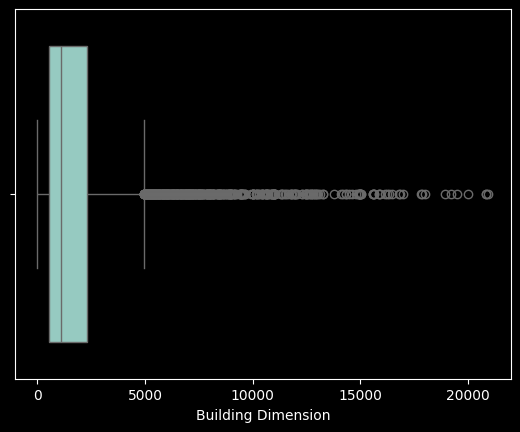

In [15]:
# Checking distribution to help decide the imputation method to use for the continous variables
sns.boxplot(x=train['Building Dimension'])
plt.show()

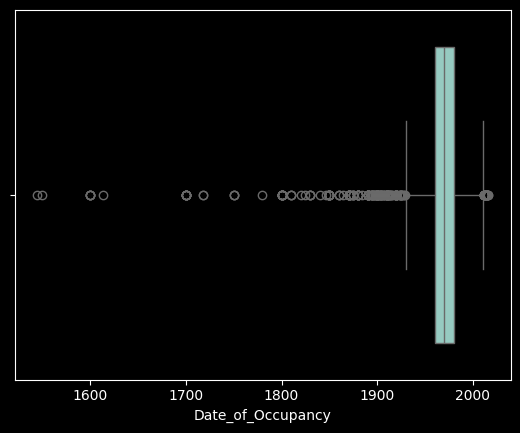

In [16]:
sns.boxplot(x=train['Date_of_Occupancy'])
plt.show()

In [18]:
# Separating the dataset as per the two types of claims
train_0 = train[train['Claim'] == 0]
train_1 = train[train['Claim'] == 1]

Compréhension des variables

In [19]:
variable_description

,Variable,Description
0,Customer Id,Identification number for the Policy holder
1,YearOfObservation,year of observation for the insured policy
2,Insured_Period,duration of insurance policy in Olusola Insura...
3,Residential,is the building a residential building or not
4,Building_Painted,"is the building painted or not (N-Painted, V-N..."
5,Building_Fenced,"is the building fence or not (N-Fenced, V-Not ..."
6,Garden,building has garden or not (V-has garden; O-no...
7,Settlement,Area where the building is located. (R- rural ...
8,Building Dimension,Size of the insured building in m2
9,Building_Type,"The type of building (Type 1, 2, 3, 4)"


Matrice de corrélation entre les variables

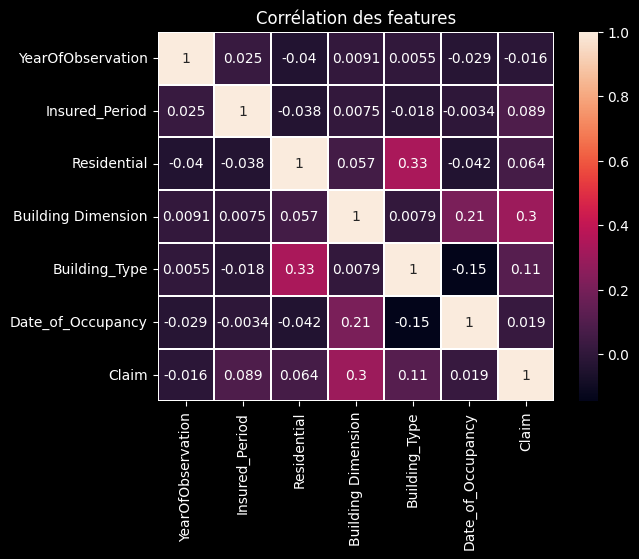

In [21]:
plt.title('Matrice de corrélation')
sns.heatmap(train.corr(numeric_only=True), linewidths=0.05, annot=True)
plt.show()

> 00 corrélation entre les variables du dataset

## 2. Preprocessing

### Deleting missing values 

In [66]:
train1 = train.copy()
test1 = test.copy()

In [69]:
train1.isnull().sum().sort_values()

Customer Id             0
YearOfObservation       0
Insured_Period          0
Residential             0
Building_Painted        0
Building_Fenced         0
Settlement              0
Building_Type           0
NumberOfWindows         0
Claim                   0
Garden                  7
Geo_Code              102
Building Dimension    106
Date_of_Occupancy     508
dtype: int64

In [70]:
test1.isnull().sum().sort_values()

Customer Id             0
YearOfObservation       0
Insured_Period          0
Residential             0
Building_Painted        0
Building_Fenced         0
Settlement              0
Building_Type           0
NumberOfWindows         0
Claim                   0
Garden                  4
Building Dimension     13
Geo_Code               13
Date_of_Occupancy     728
dtype: int64

### Dummification

In [168]:
def preprocess_data(df1: pd.DataFrame, ordinal_encoder=None, scaler=None):
    # copie du dataset
    df = df1.copy()
    # suppression de la variable d'identifiants uniques
    df.drop(ID, axis=1, inplace=True)
    # Encoder les colonnes catégoriques
    categorical_cols = list(df.select_dtypes(include='object').columns)
    if ordinal_encoder is None:
        ordinal_encoder = OrdinalEncoder()
        df[categorical_cols] = ordinal_encoder.fit_transform(
            df[categorical_cols])
    else:
        df[categorical_cols] = ordinal_encoder.transform(df[categorical_cols])

    # Normaliser les colonnes numériques
    numeric_cols = df.select_dtypes(
        include='number').columns.difference([TARGET])
    if scaler is None:
        scaler = StandardScaler()
        df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    else:
        df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

    return df

Instantiating the scalers

In [26]:
# Instantiating the scalers
MMS = MinMaxScaler()
MAS = MaxAbsScaler()
SS = StandardScaler()
RS = RobustScaler()

In [169]:
scaler = MAS
train_pp = preprocess_data(train, None, scaler)
test_pp = preprocess_data(test, None, scaler)

train_pp.head(3)

,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,0.998512,1.0,0.0,0.0,1.0,1.0,1.0,0.013849,0.0,0.972222,0.0,0.00536,0
1,0.999504,1.0,0.0,1.0,0.0,0.0,0.0,0.023400,0.0,0.917659,0.4,0.00536,0
2,0.999008,1.0,0.0,0.0,1.0,1.0,1.0,0.028415,0.0,0.972222,0.0,0.00536,0


In [121]:
test_pp.head(3)

,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,0.0,0.000000,0.0,0.0,-1.0,-1.0,-1.0,-0.403497,-1.0,-0.4,1.5,-0.504801,0
1,1.0,-0.002732,0.0,0.0,-1.0,-1.0,-1.0,-0.403497,-1.0,-0.4,1.5,-0.504801,0
2,0.0,-0.630137,0.0,0.0,0.0,0.0,0.0,-0.073974,-1.0,-0.4,0.0,-0.504801,0


## Modelling

In [100]:
def calcul_auc(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
    return auc(fpr, tpr)

### Entrainement du modèle avec CatBoost

In [176]:
X = train_pp.drop([TARGET], axis=1)
y = train_pp[TARGET]

X_Train, X_Val, y_Train, y_Val = train_test_split(X, y, test_size = 0.31, random_state=SEED)

# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
# for train_idx, val_idx in skf.split(X, y):
#     X_Train, X_Val = X.iloc[train_idx], X.iloc[val_idx]
#     y_Train, y_Val = y.iloc[train_idx], y.iloc[val_idx]

params = {
    'n_estimators': 5000,
    'learning_rate': 0.01,
    'objective': 'Logloss',
    'eval_metric': 'AUC',
    'rsm': 0.8,
    'depth': 6,
    'l2_leaf_reg': 5,
    'bagging_temperature': 1.0,
    'random_seed': 444,
    'early_stopping_rounds': 200,
    'use_best_model': True,
    'class_weights': [1, 5],  # Exemples de poids pour classes déséquilibrées
}


model_cb = CatBoostClassifier(**params)
model_cb.fit(X_Train, y_Train, eval_set=[(X_Val, y_Val)], verbose=50)

y_model_cb = model_cb.predict(X_Val)

metrique = calcul_auc(y_Val, y_model_cb)

print(f"Taux d'erreur du {str(model_cb)} : {metrique}")

0:	test: 0.7129464	best: 0.7129464 (0)	total: 3.49ms	remaining: 17.5s
50:	test: 0.7403491	best: 0.7415961 (12)	total: 181ms	remaining: 17.5s
100:	test: 0.7416813	best: 0.7417642 (99)	total: 408ms	remaining: 19.8s
150:	test: 0.7426513	best: 0.7426974 (147)	total: 610ms	remaining: 19.6s
200:	test: 0.7442956	best: 0.7443059 (199)	total: 854ms	remaining: 20.4s
250:	test: 0.7450025	best: 0.7451004 (249)	total: 1.07s	remaining: 20.2s
300:	test: 0.7456226	best: 0.7457608 (290)	total: 1.25s	remaining: 19.6s
350:	test: 0.7455420	best: 0.7457608 (290)	total: 1.48s	remaining: 19.6s
400:	test: 0.7459450	best: 0.7459450 (400)	total: 1.67s	remaining: 19.2s
450:	test: 0.7457573	best: 0.7461925 (407)	total: 1.91s	remaining: 19.2s
500:	test: 0.7457222	best: 0.7461925 (407)	total: 2.15s	remaining: 19.3s
550:	test: 0.7452029	best: 0.7461925 (407)	total: 2.37s	remaining: 19.2s
600:	test: 0.7445189	best: 0.7461925 (407)	total: 2.59s	remaining: 19s
Stopped by overfitting detector  (200 iterations wait)

bes

0.6580983568050791

0.6557632721582607

In [177]:
feature_importances = model_cb.get_feature_importance(prettified=True)
print(feature_importances)

            Feature Id  Importances
0   Building Dimension    34.981386
1       Insured_Period    14.080010
2        Building_Type     9.917502
3    Date_of_Occupancy     8.426959
4             Geo_Code     7.561631
5    YearOfObservation     7.463036
6      NumberOfWindows     7.385967
7          Residential     3.545018
8      Building_Fenced     2.266961
9     Building_Painted     1.906155
10              Garden     1.659952
11          Settlement     0.805423


Matrice de confusion

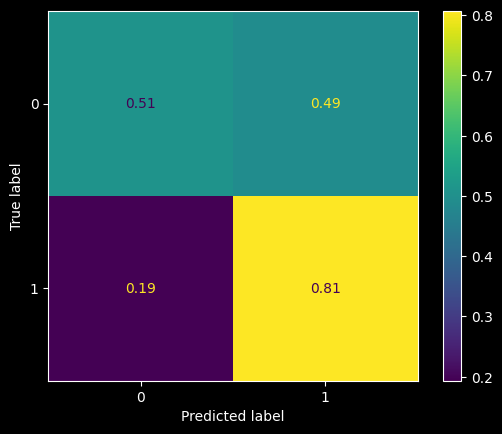

In [178]:
# traçons la matrice de confusion pour le modèle
ConfusionMatrixDisplay.from_estimator(model_cb, X_Val, y_Val, normalize='true')
plt.show()

## Prediction

In [179]:
try:
	test_pp.drop(['Claim'], axis=1, inplace=True)
except: pass

test[TARGET] = model_cb.predict(test_pp)
test.head(5)

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,H11920,2013,1.000000,0,V,N,O,R,300.0,1,1960.0,3,3310,0
1,H11921,2016,0.997268,0,V,N,O,R,300.0,1,1960.0,3,3310,0
2,H9805,2013,0.369863,0,V,V,V,U,790.0,1,1960.0,.,3310,0
3,H7493,2014,1.000000,0,V,N,O,R,1405.0,1,2004.0,3,3321,0
4,H7494,2016,1.000000,0,V,N,O,R,1405.0,1,2004.0,3,3321,0


## Submission

Visualisation du fichier d'exemple de soumission

In [44]:
sample_submission.head()

,Customer Id,Claim
0,H0,1
1,H10000,1
2,H10001,1
3,H10002,1
4,H10003,1


Création de notre fichier de soumission

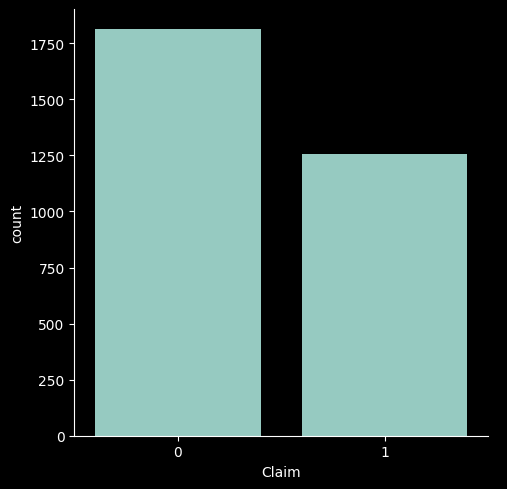

In [180]:
submissions = pd.DataFrame({ID: test[ID], TARGET: test[TARGET].astype(int)})
today = dt.now().strftime(format="%Y-%m-%d_%Hh%M")
submissions.to_csv(f'submissions/submission_{today}.csv', index=False)

# explorons la distribution de la target
sns.catplot(data=submissions, x=TARGET, kind='count')
plt.show()

## Model saving

In [129]:
# Save the model as a pickle in a file
file_name = 'catboost_gpt'
joblib.dump(model_cb, f'models/{file_name}.pkl')

['models/catboost_gpt.pkl']